# Information Retrieval

In [28]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator
import graphes
import meta
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

# Constants:
srcFolder = "cacm/" 
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata" #output folder
indexName = "cacm"


cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing ParserCACM:

In [2]:
print("##### Testing ParserCACM #####")
parser = ParserCACM.ParserCACM()
parser.initFile(cacm_txt)
doc = parser.nextDocument()
noErrors = True
nbDocs = 3205
i = 1
while doc is not None:
    docId = int(doc.getId())
    docTxt = doc.getText()
    if docId != i:
        noErrors = False
        print("Error, doc at position %d is #%d" % (i, docId))
    if docId == 1:
        if ("Preliminary Report-International Algebraic Language" not in docTxt and
        "Perlis" not in docTxt and 
        "Samelson" not in docTxt):
            print("Error, the document #1 is not as expected.")
        else:
            print("Doc #1 is as expected")
        
    elif docId == 178:
        if ("ROOTFINDER" not in docTxt and
        "Thacher" not in docTxt):
            print("Error, the document #178 is not as expected.")
        else:
            print("Doc #178 is as expected")        
            
    elif docId == 3204:
        if ("An On-Line Program for Non-Numerical Algebra" not in docTxt and
        "The goal of this program is" not in docTxt and
        "console at Stanford University." not in docTxt):
            print("Error, the document #3204 is not as expected.")
        else:
            print("Doc #3204 is as expected")        
        
    i += 1
    doc = parser.nextDocument()
    
if i == nbDocs:
    print("Success: there are %d documents as expected" % nbDocs)
else:
    print("Error, found %d docs, should contain %d docs" % (i, nbDocs))
    noErrors = False

if noErrors:
    print("##### Test: success #####")

##### Testing ParserCACM #####
Doc #1 is as expected
Doc #178 is as expected
Doc #3204 is as expected
Success: there are 3205 documents as expected
##### Test: success #####


## Testing PorterStemmer:

In [3]:
print("##### Testing PorterStemmer start    #####")
stemmer = TextRepresenter.PorterStemmer()
txtRepr = (stemmer.getTextRepresentation("Information retrieval (IR) is the activity of \
    obtaining information resources relevant to an \
    information need from a collection of information resources"))
expectDic = {'resourc':2, 'inform':4, 'relev':1,
             'retriev':1, 'activ': 1, 'obtain':1,
             'collect':1, 'ir':1}
if txtRepr != expectDic:
    print("Error, stemmer does not work as expected")
else:
    print("Stemmer works as expected")
print("##### Testing PorterStemmer finished #####")

##### Testing PorterStemmer start    #####
Stemmer works as expected
##### Testing PorterStemmer finished #####


## Testing the indexation:

In [4]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
%time idx.indexation(cacm_txt, parser, stemmer, verbose=True)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.
CPU times: user 5.11 s, sys: 528 ms, total: 5.64 s
Wall time: 6.76 s


In [5]:
print("\n###### Testing the index: ###### ")

words = ["logic", "nation", "test"]
noErrors = True
for word in words:
    idxDocContain = set(idx.getTfsForStem(word).keys())

    parser.initFile(cacm_txt)
    doc = parser.nextDocument()
    parserDocContain = set()
    while doc is not None:
        docText = doc.getText()
        docStems = stemmer.getTextRepresentation(docText).keys()
        docId = int(doc.getId())
        if word in docStems:
            parserDocContain.add(docId)
            if docId not in idxDocContain:
                print("Doc #%d contains %s: “%s”" % (docId, word, docText))
        elif docId in idxDocContain:
            print("Doc #%d should contain %s: “%s”" % (docId, word, docText))

        doc = parser.nextDocument()

    if len(idxDocContain - parserDocContain) > 0 or len(parserDocContain - idxDocContain) > 0:
        print("Step failed for word '%s'" % word)
        break
    else:
        print("Step succeeded for word '%s'." % word)
    
if noErrors:
    print("##### Test: succes #####")
else:
    print("##### Test: fail #####")


###### Testing the index: ###### 
Step succeeded for word 'logic'.
Step succeeded for word 'nation'.
Step succeeded for word 'test'.
##### Test: succes #####


In [6]:
print("Links from the 1st article:", sorted(idx.getSuccNodes('1')))
print("(Should be [43, 53, 91, ..., 1883, 1982, 3184])")
print("\nLinks from the 2nd article:", idx.getSuccNodes('2'))
print("(Should be empty)")

print("\nLinks to the 1st article:", sorted(idx.getPrevNodes('1')))
print("(Should be [43, 53, 91, ..., 1883, 1982, 3184])")
print("\nLinks to the 43rd article:", sorted(idx.getPrevNodes('43')))
print("(Should be [1, 205])")


Links from the 1st article: [43, 53, 91, 100, 123, 164, 165, 196, 205, 210, 214, 324, 398, 410, 642, 669, 1273, 1883, 1982, 3184]
(Should be [43, 53, 91, ..., 1883, 1982, 3184])

Links from the 2nd article: []
(Should be empty)

Links to the 1st article: [43, 53, 91, 100, 123, 164, 165, 196, 205, 210, 214, 324, 398, 410, 642, 669, 1273, 1883, 1982, 3184]
(Should be [43, 53, 91, ..., 1883, 1982, 3184])

Links to the 43rd article: [1, 205]
(Should be [1, 205])


In [7]:
# Choosing what to test:
test_binaryweighter = True
test_tfidfweighter = True
test_queryparser = True
test_PRrecallmeasure = True
test_averageprecision = True
test_eval_ir_model = True
test_unigram_model = True
test_okapi = True
gridsearch_language = True

## Testing the weighters:

In [8]:
query = stemmer.getTextRepresentation(" Parallel languages; languages for parallel computation")

if test_binaryweighter:
    print("\n#####Testing BinaryWeighter: #####")

    bw = modeles.BinaryWeighter(idx)
    print("bw.getDocWeightsForDoc(",docId,"):", 
        bw.getDocWeightsForDoc(docId))
    print("\nbw.getWeightsForQuery(' Parallel languages; languages for parallel computation'):", 
        bw.getWeightsForQuery(query))

    print("\n#####Testing Vectoriel with BinaryWeighter: #####")
    vect = modeles.Vectoriel(idx, bw)
    print("Top 10 documents for the previous query:")
    print("""Should include some of the following docs: 1043, 1188, 1306, 
    1358, 1396, 1491, 1923, 2246, 2316, 2527, 2699, 2710, 2715, 2716, 
    2906, 2923, 2956, 3073, 3150, """)
    print(vect.getRanking(query)[:10])
else:
    print("\n##### Skipping the test of BinaryWeighter #####")
    


#####Testing BinaryWeighter: #####
bw.getDocWeightsForDoc( 3204 ): {'mathemat': 1, '32': 1, 'teletyp': 1, 'comput': 2, 'develop': 1, 'lisp': 1, 'design': 1, 'corpor': 1, 'program': 4, 'programm': 1, 'chosen': 1, 'algebra': 1, 'korsvold': 1, 'debugg': 1, 'california': 1, '1': 1, 'consol': 1, 'obtain': 1, 'stanford': 1, 'compil': 1, 'line': 1, '5': 1, 'easi': 1, 'remot': 1, 'result': 1, 'written': 1, 'share': 1, 'access': 1, 'short': 1, 'assist': 1, 'santa': 1, 'time': 2, 'univers': 1, 'goal': 1, 'step': 1, 'te': 1, 'automat': 1, 'numer': 1, 'requir': 1, 'monica': 1}

bw.getWeightsForQuery(' Parallel languages; languages for parallel computation'): {'languag': 1, 'parallel': 1, 'comput': 1}

#####Testing Vectoriel with BinaryWeighter: #####
Top 10 documents for the previous query:
Should include some of the following docs: 1043, 1188, 1306, 
    1358, 1396, 1491, 1923, 2246, 2316, 2527, 2699, 2710, 2715, 2716, 
    2906, 2923, 2956, 3073, 3150, 
[('2785', 0.6196773353931867), ('2685', 0

In [9]:
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

if test_tfidfweighter:
    print("\n###### Testing TfidfWeighter: ###### ")
    print("tfidfWeighter.getDocWeightsForDoc(", docId, "):",
         tfidfWeighter.getDocWeightsForDoc(docId))
    print("\ntfidfWeighter.getWeightsForQuery(query):",
         tfidfWeighter.getWeightsForQuery(query))
    print("\n###### Testing Vectoriel with TfidfWeighter: ###### ")
    print("Top 10 documents for the query:")
    print(vect.getRanking(query)[:10])
else:
    print("\n##### Skipping the test of TfidfWeighter #####")


###### Testing TfidfWeighter: ###### 
tfidfWeighter.getDocWeightsForDoc( 3204 ): {'mathemat': 1, '32': 1, 'teletyp': 1, 'comput': 2, 'develop': 1, 'lisp': 1, 'design': 1, 'corpor': 1, 'program': 4, 'programm': 1, 'chosen': 1, 'algebra': 1, 'korsvold': 1, 'debugg': 1, 'california': 1, '1': 1, 'consol': 1, 'obtain': 1, 'stanford': 1, 'compil': 1, 'line': 1, '5': 1, 'easi': 1, 'remot': 1, 'result': 1, 'written': 1, 'share': 1, 'access': 1, 'short': 1, 'assist': 1, 'santa': 1, 'time': 2, 'univers': 1, 'goal': 1, 'step': 1, 'te': 1, 'automat': 1, 'numer': 1, 'requir': 1, 'monica': 1}

tfidfWeighter.getWeightsForQuery(query): {'languag': 2.063342122745655, 'parallel': 3.7154464814986583, 'comput': 1.2477816381451639}

###### Testing Vectoriel with TfidfWeighter: ###### 
Top 10 documents for the query:
[('2785', 0.58402818133982293), ('1262', 0.55022124789918558), ('2685', 0.4705180276134806), ('141', 0.4194149275774155), ('2664', 0.41617615379853456), ('2973', 0.40635424019291577), ('1306',

## Testing the QueryParser

In [13]:
if test_queryparser:
    print("\n###### Testing QueryParserCACM: ###### ")
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #3")
    while query is not None and query.getID() != "3":
        #print(query)
        #print(20*'-')
        query = qp.nextQuery()

    print("Query:", query)
    queryTxt = stemmer.getTextRepresentation(query.getText())
    print("\nCompute scores:")
    scores = vect.getRanking(queryTxt)
    print(scores[:10])
    print("Done.")
else:
    print("\n##### Skipping the test of QueryParserCACM #####")


###### Testing QueryParserCACM: ###### 
Searching for query #3
Query: Query {id=3, txt='Intermediate languages used in construction of multi-targeted compilers; TCOLL
', relevances=[1134, 1613, 1807, 1947, 2290, 2923]}

Compute scores:
[('1496', 0.25651674590511858), ('2652', 0.24068644852629345), ('205', 0.23193314713658975), ('1134', 0.22457299469588468), ('1988', 0.21538501456500694), ('799', 0.20692522553308421), ('1149', 0.19844606360359787), ('1787', 0.19049678704684123), ('3189', 0.18897240695474896), ('1788', 0.18302429425242242)]
Done.


## Testing precision/recall measure:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 10, 25]
Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
CPU times: user 272 ms, sys: 60 ms, total: 332 ms
Wall time: 378 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 28 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.035714
    2|   2 | 1.000000  |0.071429
    4|   3 | 0.750000  |0.107143
   12|   4 | 0.333333  |0.142857
   13|   5 | 0.384615  |0.178571
   19|   6 | 0.315789  |0.214286
   21|   7 | 0.333333  |0.25

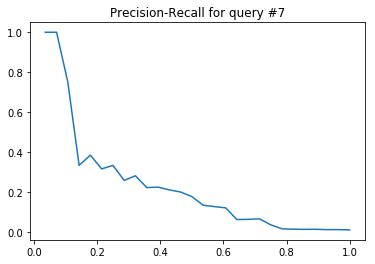

--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896, 2912, 3039, 3075, 3156]}
Retrieve scores...
CPU times: user 296 ms, sys: 148 ms, total: 444 ms
Wall time: 379 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 35 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.028571
    2|   2 | 1.000000  |0.057143
    3|   3 | 1.000000  |0.085714
    4|   4 | 1.000000  |0.114286
    5|   5 | 1.000000  |0.142857
    8|   6 | 0.750000  |0.171429
    9|   7 | 0.777778  |0.200000
   10|   8 | 0.800000  |0.228571
   11|   9 | 0.818182  |0.257143
   12|  10 | 0.833333  |0.285714
   13|  11 | 0.846154  |0.314286
   18|  12 | 0.666667  |0.342857
   19|  13 | 0.684211  |0.371429
   26|  14 | 0.538462  |0.400000
  

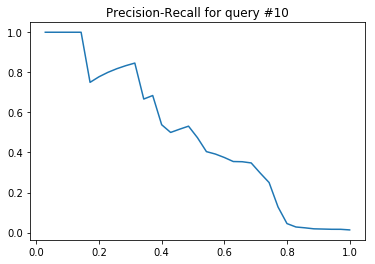

--------------------
Query: Query {id=25, txt='Performance evaluation and modelling of computer systems
', relevances=[268, 757, 963, 1408, 1518, 1526, 1533, 1572, 1653, 1698, 1719, 1805, 1892, 1901, 2085, 2095, 2218, 2277, 2318, 2319, 2358, 2373, 2434, 2452, 2535, 2582, 2667, 2668, 2669, 2681, 2741, 2765, 2798, 2818, 2831, 2859, 2862, 2863, 2881, 2918, 2928, 2984, 2988, 2996, 3006, 3048, 3059, 3067, 3088, 3089, 3119]}
Retrieve scores...
CPU times: user 304 ms, sys: 140 ms, total: 444 ms
Wall time: 387 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 51 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.019608
    2|   2 | 1.000000  |0.039216
    4|   3 | 0.750000  |0.058824
    5|   4 | 0.800000  |0.078431
    6|   5 | 0.833333  |0.098039
    7|   6 | 0.857143  |0.117647
   11|   7 | 0.636364  |0.137255
   14|   8 | 0.571429  |0.156863
   16|   9 | 0.562500  |0.176471
   17|  10 | 0.588235  |0.196078
   18|  11 | 0.611111  |0.215686
 

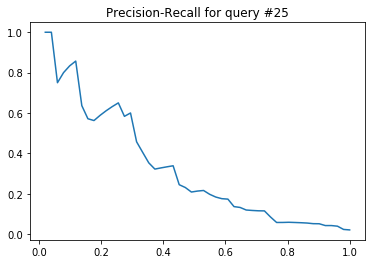

--------------------
Done.


In [14]:
if test_PRrecallmeasure:
    print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    queryChosen =[7, 10, 25]#, 14, 26, 27, 42, 43] # lots of relevant results
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #", queryChosen)
    while query is not None :
        if int(query.getID()) in queryChosen:
            print("Query:", query)
            queryTxt = stemmer.getTextRepresentation(query.getText())
            print("Retrieve scores...")
            %time ranking = vect.getRanking(queryTxt)
            print("Create PrecisionRecallMeasure object")
            irlist = evaluation.IRList(query, ranking)
            precisRecall = evaluation.PrecisionRecallMeasure(irlist)
            print("Evaluate the scores.")
            pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
            precision = [p for r,p in pr]
            recall = [r for r,p in pr]
            plt.plot(recall, precision)
            plt.title("Precision-Recall for query #"+query.getID())
            plt.show()
            print(20*'-')


        query = qp.nextQuery()
    print("Done.")
else:
    print("\n##### Skipping the test of PrecisionRecallMeasure #####")

## Testing average precision:

In [15]:
if test_averageprecision:
    print("\n###### Testing evaluation.AveragePrecision: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    #queryChosen =[7, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #",queryChosen, "\n")
    while query is not None :
        if int(query.getID()) in queryChosen:
            print("Query:", query)
            queryTxt = stemmer.getTextRepresentation(query.getText())
            print("Retrieve scores...")
            scores = vect.getRanking(queryTxt)
            irlist = evaluation.IRList(query, scores)
            average_measure = evaluation.AveragePrecision(irlist)
            print("Evaluate the scores.")
            average_prec = average_measure.eval(verbose=True)
            print("Average precision: %f" % average_prec)
            print(20*'-')

        query = qp.nextQuery()
    print("Done.")
else:
    print("\n##### Skipping the test of AveragePrecision #####")


###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [40  4 10 16 23 33 18  5 45 33] 

Query: Query {id=4, txt='I'm interested in mechanisms for communicating between disjoint processes,
possibly, but not exclusively, in a distributed environment.  I would
rather see descriptions of complete mechanisms, with or without implementations,
as opposed to theoretical work on the abstract problem.  Remote procedure
calls and message-passing are examples of my interests.
', relevances=[1749, 1811, 2256, 2371, 2597, 2796, 2912, 3043, 3073, 3082, 3127, 3128]}
Retrieve scores...
Evaluate the scores.
This query has 12 relevant results
   i |found| precision
    2|   1 | 0.500000
    7|   2 | 0.285714
   38|   3 | 0.078947
  109|   4 | 0.036697
  110|   5 | 0.045455
  111|   6 | 0.054054
  164|   7 | 0.042683
  374|   8 | 0.021390
  479|   9 | 0.018789
  834|  10 | 0.011990
  903|  11 | 0.012182
 2548|  12 | 0.004710
Average precision: 0.092718
--------------------
Query: Quer

## Testing EvalIRModel:

In [16]:
if test_eval_ir_model:
    print("\n###### Testing evaluation.EvalIRModel: ###### ")
    queryChosen = np.random.randint(1, 50, size=50)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
        query = qp.nextQuery()
    print("Found queries")
    irmodels = {"vectoriel bw": modeles.Vectoriel(idx, bw),
                "vectoriel tfidf": modeles.Vectoriel(idx, tfidfWeighter)}
    measures = {"averagePrecision": evaluation.AveragePrecision}
    eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
    print("Calling eval()...")
    print(eval_model.eval(verbose=False))
    print("Done.")
else:
    print("\n##### Skipping the test of EvalIRModel #####")


###### Testing evaluation.EvalIRModel: ###### 
Searching for queries # [42 45 16 39 38 36 47 46  7 18  3  6 48  7 36  8 30 39 48 46 36 18 41 43 30
 12 22 42  4 10 24 47  3 11 34 16 47 17 28 22 38  9 31 28  7 23 29 35 24 38] ...
Found queries
Calling eval()...
{('vectoriel bw', 'averagePrecision'): (0.20720674243798812, 0.21652183052811597), ('vectoriel tfidf', 'averagePrecision'): (0.26664704851514254, 0.2366267731781441)}
Done.


## Testing the unigram language model:

In [17]:
if test_unigram_model:
    print("\n###### Testing Unigram language: ###### ")
    queryChosen = np.random.randint(1, 50, size=3)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    relevants = {} #dict of {query id : list of relevant doc id}
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
            relevants[query.getID()] = list(query.getRelevants().keys())
            #print(query)
        query = qp.nextQuery()
    print("Found queries")
    model = modeles.UnigramLanguage(idx, 0.8)
    for q, (q_id, relev) in zip(queries, relevants.items()):
        print(q)
        print("Scores for 3 relevant docs:")
        for doc_id in np.random.choice(relev, size=3):
            print(doc_id, model.score(stemmer.getTextRepresentation(q.getText()), doc_id))
        print("Scores for 3 random docs:")
        for doc_id in np.random.choice(idx.getDocsID(), size=3):
            if doc_id in relev:
                print("Doc #", doc_id, "Relevant doc")
            else:
                stems = ','.join(idx.getTfsForDoc(doc_id).keys())
                print("Irrelevant doc #", doc_id, stems)
                print("Score for this doc:", 
                      model.score(stemmer.getTextRepresentation(q.getText()), doc_id))
        print(20*'-')
    print("Done.")
else:
    print("\n##### Skipping the test of LanguageModel #####")


###### Testing Unigram language: ###### 
Searching for queries # [22 32 21] ...
Found queries
Query {id=21, txt='computational complexity, intractability, class-complete reductions,
algorithms and efficiency
', relevances=[1429, 1847, 2189, 2490, 2603, 2701, 2702, 2703, 2932, 3018, 3139]}
Scores for 3 relevant docs:
2828 -56.7206587224
2473 -61.8728853918
2761 -61.2792269778
Scores for 3 random docs:
Irrelevant doc # 170 set,voorhe,thought,charact,reconcil,propos
Score for this doc: -64.7861215784
Irrelevant doc # 2043 real,symmetric,qr,f2,eigenvector,384,eigenvalu,stewart,matrix,algorithm
Score for this doc: -61.4084832503
Irrelevant doc # 1647 achiev,waterloo,diagnost,overhead,virtual,extens,maximum,fortran,error,compat,compil,operat,watfor,translat,alik,learn,ibm,implement,select,7040,process,execut,phase,speed,100,order,core,princip,mitchel,german,student,44,languag,resid,sourc,iv,learner,program,attract,system,larg,run,shantz,batch,effici,univers,statement,user,featur,advantag,lo

##  Testing Okapi language model:

In [18]:
if test_okapi:
    print("\n###### Testing Okapi: ###### ")
    queryChosen = np.random.randint(1, 50, size=3)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    relevants = {} #dict of {query id : list of relevant doc id}
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
            relevants[query.getID()] = list(query.getRelevants().keys())
            #print(query)
        query = qp.nextQuery()
    print("Found queries")
    
    okapi = modeles.Okapi(idx, k=1, b=1)
    for q, (q_id, relev) in zip(queries, relevants.items()):
        print(q)
        print("Scores for 3 relevant docs:")
        for doc_id in np.random.choice(relev, size=3):
            stems = ','.join(idx.getTfsForDoc(doc_id).keys())
            print("Relevant doc #", doc_id, stems)
            print("Score:", 
                  okapi.score(stemmer.getTextRepresentation(q.getText()), doc_id, verbose=True))
        print("Scores for 3 random docs:")
        for doc_id in np.random.choice(idx.getDocsID(), size=3):
            if doc_id in relev:
                print("Doc #", doc_id, "Relevant doc")
            else:
                stems = ','.join(idx.getTfsForDoc(doc_id).keys())
                print("Irrelevant doc #", doc_id, stems)
                print("Score for this doc:", 
                      okapi.score(stemmer.getTextRepresentation(q.getText()), doc_id, verbose=True))
        print(20*'-')
    print("Done.")
else:
    print("\n##### Skipping the test of Okapi #####")


###### Testing Okapi: ###### 
Searching for queries # [20 32  2] ...
Found queries
Query {id=2, txt='I am interested in articles written either by Prieve or Udo Pooch
', relevances=[2434, 2863, 3078]}
Scores for 3 relevant docs:
Relevant doc # 2695 earli,standard,pool,explicit,jr,tridiagonaliz,import,method,error,tool,permut,eigenvalu,algebra,theoret,time,column,linear,includ,determin,improv,bandwidth,matrix,number,assign,examin,arbitrari,comput,class,increment,row,comparison,matric,gibb,compar,algorithm,absenc,similar,round,arithmet,spars,tridiagon,graph,occur,transform,reject,requir,favor,form,consid,numer,advantag,correspond
Doc 2695 len= 81 meanLean= 35.59769038701623
weight for articl: 0.0
weight for pooch: 0.0
weight for written: 0.0
weight for priev: 0.0
weight for udo: 0.0
weight for interest: 0.0
Score: 0.0
Relevant doc # 1563 problem,generaliz,appli,path,graph,pohl,knight,find,rule,tour,method,hamilton,warnsdorff,theoret,justif
Doc 1563 len= 23 meanLean= 35.59769038701623
we

In [19]:
print("\n###### Testing Okapi & AveragePrecision: ###### ")
for query in queries:
    print("Query:", query)
    queryTxt = stemmer.getTextRepresentation(query.getText())
    print("Retrieve scores...")
    scores = okapi.getRanking(queryTxt)
    irlist = evaluation.IRList(query, scores)
    average_measure = evaluation.AveragePrecision(irlist)
    print("Evaluate the scores.")
    average_prec = average_measure.eval(verbose=True)
    print("Average precision: %f" % average_prec)
    print(20*'-')

print("Done.")


###### Testing Okapi & AveragePrecision: ###### 
Query: Query {id=2, txt='I am interested in articles written either by Prieve or Udo Pooch
', relevances=[2434, 2863, 3078]}
Retrieve scores...
Evaluate the scores.
This query has 3 relevant results
   i |found| precision
    3|   1 | 0.333333
   10|   2 | 0.200000
   13|   3 | 0.230769
Average precision: 0.254701
--------------------
Query: Query {id=20, txt='Graph theoretic algorithms applicable to sparse matrices
', relevances=[1563, 2695, 2986]}
Retrieve scores...
Evaluate the scores.
This query has 3 relevant results
   i |found| precision
    1|   1 | 1.000000
    4|   2 | 0.500000
    5|   3 | 0.600000
Average precision: 0.700000
--------------------
Query: Query {id=32, txt='I'd like to find articles describing graph algorithms that are based on
the eigenvalue decomposition (or singular value decomposition) of the
ajacency matrix for the graph.  I'm especially interested in any heuristic
algorithms for graph coloring and graph i

## Comparison of language models:

In [21]:
from sklearn.model_selection import train_test_split
import itertools 

# Searching queries:
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found all queries")

q_train, q_test = train_test_split(queries)

# Train models, find best parameters.

def dict_combinations(dic):
    keys = dic.keys()
    #print(keys)
    values = [dic[key] for key in keys]
    #print("values:", list(values), ".")
    #for combination in itertools.product(*values):
        #print(combination)
    combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
    return combinations

def gridsearch(model_class, param_grid, queries, measure_object, verbose=False):
    """
    :param model_class: modeles.Vectoriel for instance (the class, not an instance)
    :param param_grid: dict of {string:iterable}
    :param queries: list of Query objects
    :param measure_class: evaluation.AveragePrecision() for instance
    """
    params = []
    irmodels = {}
    for i, comb in enumerate(dict_combinations(param_grid)):
        params.append(comb)
        irmodels[i] = model_class(**comb)
    eval_models = evaluation.EvalIRModel(queries, irmodels, {'measure':measure_object})
    if verbose:
        print("Calling eval()")
        scores = eval_models.eval(verbose=verbose)
        for k,v in scores.items():
            print(params[k[0]])
            print("--->", v[0])
    else:
        scores = eval_models.eval()
    best_irmodel = max(scores.keys(), key=(lambda key: scores[key][0]))[0]
    return params[best_irmodel]

gridsearch_language = False
if gridsearch_language:
    unigram_params_grid = {'index':[idx], 'regularization':np.linspace(0,1, 20)}

    #c = dict_combinations(params_grid)
    #print("comb: ",c)

    best_unigram_params = gridsearch(modeles.UnigramLanguage, unigram_params_grid, 
                     q_train, evaluation.AveragePrecision, verbose=1)
else:
    best_unigram_params = {'index': idx, 'regularization': 0.36842105263157893}



Searching for queries # [20 32  2] ...
Found all queries


In [22]:
if gridsearch_language:
    okapi_params_grid = {'index':[idx], 'k':np.linspace(1, 2, 10), 'b':np.linspace(0,2,10)}
    best_okapi_params = gridsearch(modeles.Okapi, okapi_params_grid, 
                 q_train, evaluation.AveragePrecision, verbose=1)

else:
    best_okapi_params = {'index': idx, 'k': 2.0, 'b': 0.5}

### Execution on the test set:

In [23]:
print("best unigram params:", best_unigram_params)
print("best okapi params:", best_okapi_params)

irmodels = {'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)}

eval_models = evaluation.EvalIRModel(q_test, irmodels, {'measure':evaluation.AveragePrecision})
scores = eval_models.eval(verbose=True)
print(scores)

best unigram params: {'regularization': 0.3684210526315789, 'index': <indexation.Index object at 0x7ff74c39dfd0>}
best okapi params: {'b': 0.5, 'k': 2.0, 'index': <indexation.Index object at 0x7ff74c39dfd0>}
[  0/  2] IRModel 'unigram'
Measure: measure
(0.67628205128205121, 0.0)
[  1/  2] IRModel 'okapi'
Measure: measure
(0.57222222222222219, 0.0)
{('okapi', 'measure'): (0.57222222222222219, 0.0), ('unigram', 'measure'): (0.67628205128205121, 0.0)}


## Meta Model

In [37]:
# 3 models:
binWeighter = modeles.BinaryWeighter(idx)
vect_binary = modeles.Vectoriel(idx, binWeighter)
tfidfWeighter = modeles.TfidfWeighter(idx)
vect_tfidf = modeles.Vectoriel(idx, tfidfWeighter)
unigram = modeles.UnigramLanguage(**best_unigram_params)

list_model = [vect_binary, vect_tfidf, unigram]
list_featurers_model = [meta.FeaturerModel(idx, model) for model in list_model]
list_featurers = [meta.DocLenFeaturer(idx), meta.QueryLenFeaturer(idx)] + list_featurers_model
featurers = meta.FeaturerList(idx, list_featurers)
meta_model = meta.MetaModel(idx, featurers, stemmer=stemmer)
# TODO Grid Search on alpha, lambda
meta_model.train(q_train, max_iter = 10, lr=0.01, regul_coef=2)


Featurers: [<meta.DocLenFeaturer object at 0x7ff720e4bd68>, <meta.QueryLenFeaturer object at 0x7ff720e4bcc0>, <meta.FeaturerModel object at 0x7ff720e4bbe0>, <meta.FeaturerModel object at 0x7ff720e4bb38>, <meta.FeaturerModel object at 0x7ff720e4bd30>]


In [43]:
print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen = np.random.randint(1, 50, size=10)
#queryChosen =[7, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen, "\n")
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = meta_model.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=True)
        print("Average precision: %f" % average_prec)
        print(20*'-')

    query = qp.nextQuery()
print("Done.")



###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [31  4  7 39 20 40 33 29  4 11] 

Query: Query {id=4, txt='I'm interested in mechanisms for communicating between disjoint processes,
possibly, but not exclusively, in a distributed environment.  I would
rather see descriptions of complete mechanisms, with or without implementations,
as opposed to theoretical work on the abstract problem.  Remote procedure
calls and message-passing are examples of my interests.
', relevances=[1749, 1811, 2256, 2371, 2597, 2796, 2912, 3043, 3073, 3082, 3127, 3128]}
Retrieve scores...
Evaluate the scores.
This query has 12 relevant results
   i |found| precision
    1|   1 | 1.000000
   19|   2 | 0.105263
   32|   3 | 0.093750
   81|   4 | 0.049383
  147|   5 | 0.034014
  178|   6 | 0.033708
  181|   7 | 0.038674
  444|   8 | 0.018018
  463|   9 | 0.019438
  879|  10 | 0.011377
 1019|  11 | 0.010795
 2666|  12 | 0.004501
Average precision: 0.118243
--------------------
Query: Quer